# | NLP | LLM | Society | Bias Toxicity |

## Natural Language Processing (NLP) and Large Language Models (LLM), LLM with Society, Bias and toxicity


![Learning](https://t3.ftcdn.net/jpg/06/14/01/52/360_F_614015247_EWZHvC6AAOsaIOepakhyJvMqUu5tpLfY.jpg)


# <b>1 <span style='color:#78D118'>|</span> Overview</b>

This notebook covers various aspects related to language models, with a focus on societal implications. Here's an overview of the main sections:

## Learning Objectives

In this section, learning objectives are outlined, emphasizing the following points:

1. Understanding representation bias in training data.
2. Using Hugging Face to calculate toxicity scores.
3. Using SHAP to generate explanations for model output.
4. Exploring the latest research advancements in model explanation: contrastive explanation.

### Setup


In [1]:
import os

os.environ["HUGGINGFACEHUB_API_TOKEN"] = "Fill"

In [14]:
%%capture
!pip install disaggregators==0.1.2 https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.5.0/en_core_web_lg-3.5.0-py3-none-any.whl
!pip install evaluate    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
cache_dir = "./cache"

In [4]:
import pandas as pd
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

# <b>2 <span style='color:#78D118'>|</span> Bias</b>

### Examining representation bias in Dataset

[Disaggregators](https://github.com/huggingface/disaggregators) is a library developed by Hugging Face. As the name implies, it "dis-aggregates" data so that we can explore the data in more granular detail and evaluate data bias.

There are multiple disaggregation modules available: 
- age
- gender
- religion
- continent
- pronoun

We will be loading Wikipedia bios as our datasets to analyze later. We will be using the `pronoun` module since it takes the least amount of time to dis-aggregate. You are welcome to try out other modules in your own time. 

**IMPORTANT**:
- For `gender` disaggregator to work, you need to download spacy's `en_core_web_lg` model. 
    - That's the model Hugging Face is using behind the scene! 
    - Hence, you can see the `.whl` file install in the `%pip install` command above. 
    - The model is directly download from [spaCy's GitHub](https://github.com/explosion/spacy-models/releases?q=en_core_web_lg).

In [5]:
from disaggregators import Disaggregator

disaggregator = Disaggregator("pronoun", column="target_text")
# disaggregator = Disaggregator("gender", column="target_text")
# disaggregator = Disaggregator("continent", column="target_text")
# disaggregator = Disaggregator("religion", column="target_text")
# disaggregator = Disaggregator("age", column="target_text")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We will use [Wikipedia biographies dataset](https://huggingface.co/datasets/wiki_bio), `wiki_bio`, readily available in the Hugging Face Datasets. From the dataset summary, the data contains the first paragraph of the biography and the tabular infobox. 

As you see, disaggreator works with Hugging Face datasets or any datasets where `.map` can be invoked. The `disaggregators` library attempts to group the wiki bio into `she_her`, `he_him`, and `they_them`.

Note: the cell below might take a couple minutes for the data to finish loading and for the disaggregator to categorize the data.


In [6]:
from datasets import load_dataset

wiki_data = load_dataset(
    "wiki_bio", 
    split="test", 
    cache_dir=cache_dir
)  # Note: We specify cache_dir to use pre-cached data.
ds = wiki_data.map(disaggregator)
pdf = ds.to_pandas()

Generating train split:   0%|          | 0/582659 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/72831 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/72831 [00:00<?, ? examples/s]

Dataset wiki_bio downloaded and prepared to ./cache/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da. Subsequent calls will reuse this data.


  0%|          | 0/72831 [00:00<?, ?ex/s]

In [7]:
pdf.head(10)

,input_text,target_text,pronoun.she_her,pronoun.he_him,pronoun.they_them
0,"{'table': {'column_header': ['birth_place', 'debutdate', 'debutyear', 'article_title', 'debutteam', 'finalyear', 'finalteam', 'statlabel', 'position', 'statvalue', 'bats', 'throws', 'finaldate', 'name', 'birth_date'], 'row_number': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'content': ['long beach , california', 'june 16', '1971', 'lenny randle ', 'washington senators', '1982', 'seattle mariners', 'batting average home runs runs batted in', 'second baseman / third baseman', '.257 27 322'...","leonard shenoff randle -lrb- born february 12 , 1949 -rrb- is a former major league baseball player .\nhe was the first-round pick of the washington senators in the secondary phase of the june 1970 major league baseball draft , tenth overall .\n",False,True,False
1,"{'table': {'column_header': ['birth_place', 'caption', 'article_title', 'party', 'occupation', 'term_end', 'office', 'constituency', 'residence', 'term_start', 'birth_date'], 'row_number': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'content': ['france', 'philippe adnot', 'philippe adnot ', 'independent/mouvement libéral et modéré', 'farmer', 'incumbent incumbent', 'senator aube councillor , general council of aube , french senate president , general council of', 'aube canton de méry-sur-seine', 'fra...","philippe adnot -lrb- born 25 august 1945 in rhèges -rrb- is a member of the senate of france .\nhe was first elected in 1989 , and represents the aube department .\na farmer by profession , he serves as an independent , and also serves as the head of the general council of aube , to which he was elected to represent the canton of méry-sur-seine in 1980 .\nin 1998 and 2008 , he was re-elected to the senate in the first round , avoiding the need for a run-off vote .\nhaving contributed to the ...",False,True,False
2,"{'table': {'column_header': ['birth_place', 'nationality', 'article_title', 'name', 'birth_date'], 'row_number': [1, 1, 1, 1, 1], 'content': ['dvůr králové nad labem , czech republic', 'cze czech', 'miroslav popov ', 'miroslav popov', '14 june 1995']}, 'context': 'miroslav popov '}",miroslav popov -lrb- born 14 june 1995 in dvůr králové nad labem -rrb- is a czech grand prix motorcycle racer .\nhe currently races in the fim cev moto2 championship for montaze broz racing team aboard a suter .\n,False,True,False
3,"{'table': {'column_header': ['birth_place', 'nationalcaps', 'article_title', 'youthyears', 'years', 'caps', 'goals', 'death_date', 'nationalteam', 'nationalyears', 'youthclubs', 'nationalgoals', 'fullname', 'height', 'position', 'birth_date', 'name', 'image', 'death_place', 'clubs', 'image_size'], 'row_number': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'content': ['blackburn , england', '5 8 4', 'jack reynolds -lrb- footballer , born 1869 -rrb- ', '1884 -- 1885 1886', ...","john `` jack '' reynolds -lrb- 21 february 1869 -- 12 march 1917 -rrb- was a footballer who played for , among others , west bromwich albion , aston villa and celtic .\nas an international he played five times for ireland before it emerged that he was actually english and he subsequently played eight times for england .\nhe is the only player , barring own goals , to score for and against england and is the only player to play for both ireland and england .\nhe won the fa cup with west bromw...",False,True,False
4,"{'table': {'column_header': ['alias', 'birth_place', 'label', 'article_title', 'birth_name', 'genre', 'background', 'origin', 'image', 'years_active', 'associated_acts', 'name', 'occupation', 'instrument', 'birth_date'], 'row_number': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'content': ['akoo nana', 'ghana , accra', '4ever records -lrb- 2009 -- present -rrb-', 'akoo nana ', 'william ato ankrah', 'dancehall , hiplife', 'solo_singer', 'ghanaian', 'file : akoo nana.jpg', '2012 -- present'...","william ato ankrah , -lrb- born 7th july 1979 -rrb- better known by his stage name akoo n

However, it doesn't do a very a good job at determining `they_them` as it seems to classify mentions of physical objects as `they_them` as well. For example, the 19th row has both pronoun categories, `they_them` and `he_him`, to be true. But looking at the data itself, we saw that the bio only used the the pronoun `he_him`: 

>william ` bill ' rigby -lrb- 9 june 1921 - 1 june 2010 -rrb- was a former english footballer who played as a goalkeeper .\nhe was born in chester .\na product of the youth system at his hometown club of chester , rigby made his only peacetime first-team appearance for the club in their first post-war match in the football league in a 4 -- 4 draw at york city on 31 august 1946 .\nafter this he was not selected again , with goalkeeping duties being passed on to george scales and jim maclaren .\nearlier he had made appearances for the first-team during the war years , mainly during 1940 -- 41 and 1941 -- 42 while understudy to bill shortt

For this reason, the following analysis will ignore the column `pronoun.they_them`.


In [8]:
import json

print(pdf.iloc[[19], :].to_json(indent=4))


{
    "input_text":{
        "19":{
            "table":{
                "column_header":[
                    "birth_place",
                    "currentclub",
                    "article_title",
                    "youthyears",
                    "caps",
                    "position",
                    "goals",
                    "youthclubs",
                    "clubs",
                    "name",
                    "death_date",
                    "fullname",
                    "years",
                    "birth_date"
                ],
                "row_number":[
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1
                ],
                "content":[
                    "chester , england",


Let's do a simple aggregation to check the ratio of Wikipedian bios in terms of `he_him` 

In [9]:
import numpy as np

she_array = np.where(pdf["pronoun.she_her"] == True)
print(f"she_her: {len(she_array[0])} rows")
he_array = np.where(pdf["pronoun.he_him"] == True)
print(f"he_him: {len(he_array[0])} rows")

she_her: 9545 rows
he_him: 44004 rows


### Bias of pre-trained LLM model BERT

The `he_him` pronoun represents `44004/ (9545+44004)`, which is approximately 82% of the data! It is not hard to imagine that models trained on predominantly male data would exhibit bias towards males.

Let's confirm that existing pre-trained models, like BERT, does exhibit bias. BERT is trained on both Wikipedia and [books that are adapted into movies](https://huggingface.co/datasets/bookcorpus). 

In [10]:
from transformers import pipeline

unmasker = pipeline(
    "fill-mask",
    model="bert-base-uncased",
    model_kwargs={"cache_dir": cache_dir},
)  # Note: We specify cache_dir to use pre-cached models.


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

 To probe what BERT outputs, we will intentionally insert [MASK] token and ask BERT to generate words to replace that [MASK] token.
 
 
[fill-mask](https://huggingface.co/tasks/fill-mask)


<img src="https://raw.githubusercontent.com/YanSte/NLP-LLM-Society-Bias-Toxicity/main/img_1.png" alt="Learning" width="50%">


In [12]:
result = unmasker("This woman works as a [MASK].")
print([r["token_str"] for r in result])

result = unmasker("This man works as a [MASK].")
print([r["token_str"] for r in result])

['nurse', 'maid', 'teacher', 'waitress', 'prostitute']
['carpenter', 'lawyer', 'farmer', 'businessman', 'doctor']


1. The BERT model is used to predict masked words in sentences.
2. For the sentence "This woman works as a [MASK]," BERT suggests occupation-related words such as 'nurse,' 'maid,' 'teacher,' 'waitress,' and 'prostitute.'
3. For the sentence "This man works as a [MASK]," BERT suggests a different set of occupation-related words, including 'carpenter,' 'lawyer,' 'farmer,' 'businessman,' and 'doctor.'

The output highlights the **potential biases present in BERT's predictions, revealing gender-stereotyped occupational suggestions for women and men.** 
This underlines the importance of critically assessing and mitigating biases in language models to ensure fair and unbiased results.

# <b>3 <span style='color:#78D118'>|</span> Toxicity</b>

Now that we have inspected data and model bias above, let's evaluate the toxicity of language model outputs. To do this, we leverage another [Hugging Face library called `evaluate`](https://huggingface.co/docs/evaluate/index).

The `evaluate` library can measure language models from different angles:
<br>
 - **Toxicity:** how problematic the completion is, such as hate speech
   - It uses [Facebook's `roberta-hate-speech-dynabench-r4-target` model](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target) behind the scene to compute toxicity.
 - **[HONEST](https://huggingface.co/spaces/evaluate-measurement/honest):** how hurtful the completion is 
   - The model was [published in 2021](https://aclanthology.org/2021.naacl-main.191.pdf)
   - It works very similarly as our `unmasker` example in the cell directly above. It also replaces certain words with [MASK] tokens and evaluates the hurtfulness based on what the language models output.
 - **Regard:** whether the completion regards a certain group higher than the others 
   - You will play with this in the lab! So we will save this for later. 


In [15]:
import evaluate

toxicity = evaluate.load("toxicity", module_type="measurement")

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Any toxicity value over 0.5 is arbitrarily defined as "toxic". Here, we refrain from typing literal curse words to increase the toxicity values. However, you can see that the third phrase is noticeably more toxic than the other two! 

In [16]:
candidates = [
    "their kid loves reading books",
    "she curses and makes fun of people",
    "he is a wimp and pathetic loser",
]
toxicity.compute(predictions=candidates)

{'toxicity': [0.00013759217108599842,
  0.021460149437189102,
  0.08053278923034668]}

# <b>4 <span style='color:#78D118'>|</span> Model Interpretability with SHAP</b>

Another interesting topic within language model evaluation is whether we can interpret LM outputs. **SH**apley **A**dditive ex**P**lanations (**SHAP**) is a popular approach to explain the output of a machine learning model. It is agnostic to the type of machine learning model you pass in; this means that we can try using SHAP to explain our language model outputs! 

See the <a href="http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions" target="_blank">SHAP NeurIPS</a> paper for details, and Christoph Molnar's book chapter on <a href="https://christophm.github.io/interpretable-ml-book/shapley.html" target="_blank">Shapley Values</a>. 

Take the diagram below as an example. SHAP's goal is to explain the $ 10,000 difference in the apartment price. We see that if cats are not allowed in the same apartment building, the price of the apartment is lower than if it were to allow cats. 

<img src="https://christophm.github.io/interpretable-ml-book/images/shapley-instance-intervention.png" width=500>

Image is sourced from Molnar's book. Read SHAP [documentation here](https://shap.readthedocs.io/en/latest/text_examples.html).


In this section, we are going to first load a text generation model from Hugging Face, provide an input sentence, and ask the model to complete the rest of the sentence. Then, we will ask SHAP to generate explanation behind the sentence completion.


In [17]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import shap

tokenizer = AutoTokenizer.from_pretrained(
    "gpt2", 
    use_fast=True, 
    cache_dir=cache_dir
)
model = AutoModelForCausalLM.from_pretrained("gpt2", cache_dir=cache_dir)

# Set model decoder to true
# GPT is a decoder-only model
model.config.is_decoder = True
# We set configurations for the output text generation
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0,  # to turn off randomness
    "top_k": 50,
    "no_repeat_ngram_size": 2,
}


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [18]:
input_sentence = ["Sunny days are the best days to go to the beach. So"]

The `shap.Explainer` is how we can interface with SHAP. We need to pass in our `tokenizer` because that's the tokenizer we use to vectorize the text. When SHAP masks certain tokens to generate explanation, the tokenizer helps us to retain the same number of tokens by replacing the word with the [MASK] token.


In [19]:
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(input_sentence)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.


  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.58s/it]               


Now we can check the contribution of each input token towards the output token. "Red" means positive contribution whereas "blue" means negative indication. The color intensity indicates the strength of the contribution. 

From the documentation:

> The base value is what the model outputs when the entire input text is masked, while f_outputclass(inputs)
is the output of the model for the full original input. The SHAP values explain in an additive way how the impact of unmasking each word changes the model output from the base value (where the entire input is masked) to the final prediction value


In [20]:
shap.plots.text(shap_values)

The plot below shows which input tokens contributes most towards the output token `looking`. 

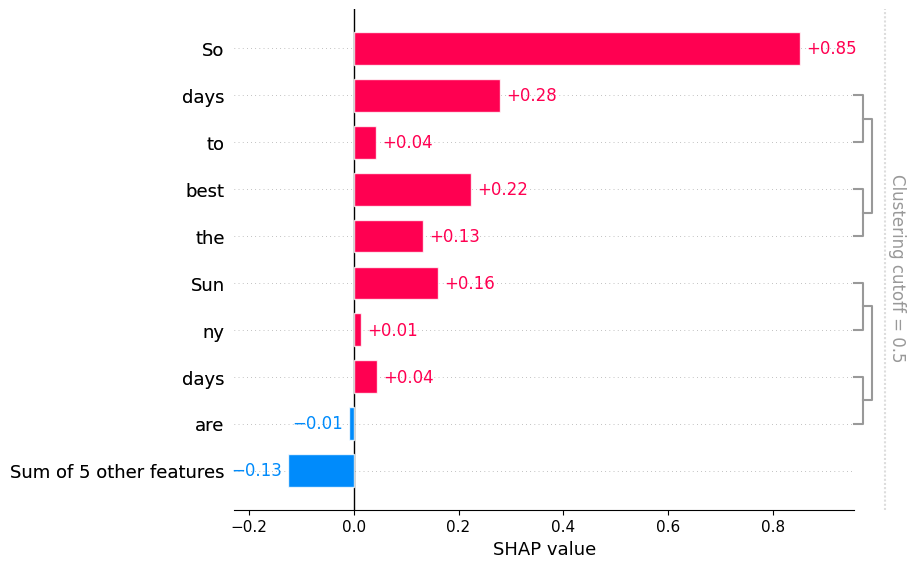

In [21]:
shap.plots.bar(shap_values[0, :, "looking"])

In [22]:
input_sentence2 = ["I know many people who prefer beaches to the mountains"]
shap_values2 = explainer(input_sentence2)
shap.plots.text(shap_values2)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.


 Let's check which token contributes the most to the output word "not".

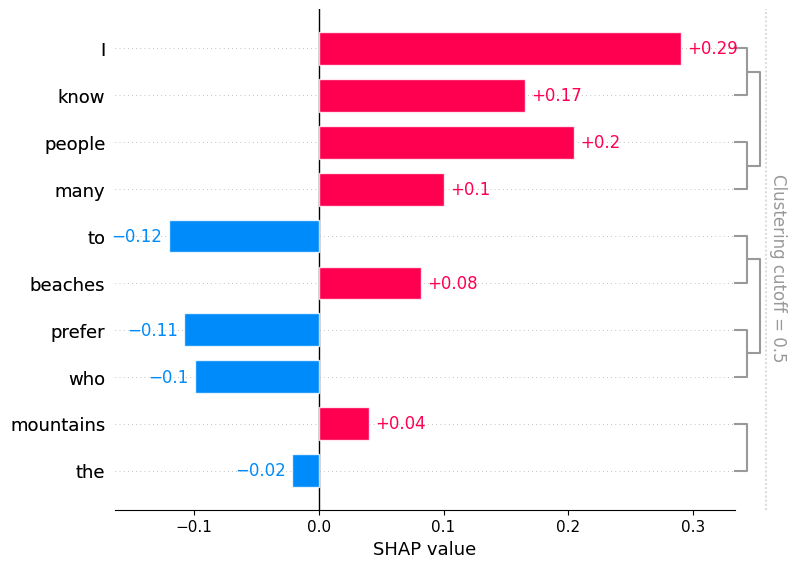

In [23]:
shap.plots.bar(shap_values2[0, :, "not"])

Common model interpretability methods for text classification are not as informative for language model predictions because the most recent input token usually is the most influential token to the subsequent predicted token. This is called recency bias and it's a difficult problem to tackle. While SHAP gave us an idea what input token may have contributed to the output token, it's not really all that useful. 

Let's take a look at the final example.

In [24]:
input_sentence3 = ["Can you stop the dog from"]
shap_values3 = explainer(input_sentence3)
shap.plots.text(shap_values3)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# <b>5 <span style='color:#78D118'>|</span> Exploring the latest research advancements in model explanation: contrastive explanation.</b>

In the example above, we see that the predicted token is `barking`. But we don't know why the model doesn't output tokens like `crying`, `eating`, `biting`, etc. It would be a lot more interesting if we can know *why* the model outputs `barking` **instead of** `crying` and other viable word candidates. This `instead of` explanation is called `contrastive explanation` ([Yin and Neubig 2022](https://aclanthology.org/2022.emnlp-main.14.pdf)). 


Let the actual output token be `target_token` and the viable output token be `foil_token`. Intuitively, there are three methods to generate such contrastive explanations: 
1. Calculate how much an input token influences the probability of `target_token`, while decreasing the probability of `foil_token`
2. Calculate how much erasing an input token increases the probability of `foil_token` and reduces that of `target_token` 
3. Calculate the dot product between the input token embedding and the output token. 

<img src="https://files.training.databricks.com/images/constrastive_exp.png" width=300>

Courtesy of the author's, Kayo Yin's, [slides](https://kayoyin.github.io/assets/slides/melb22.pdf). Below, we are going to use Yin's [Python module](https://github.com/kayoyin/interpret-lm/tree/main) to generate contrastive explanation for us! The code is currently in a research state, rather than readily packaged on PyPI or production-ready, but it is still interesting to see current (and potential future) state of research directions.

We will walk through the results directly in the markdown. If you are interested in running this code, you can download `lm_saliency.py` from the [repo](https://github.com/kayoyin/interpret-lm/blob/main/lm_saliency.py).



In [25]:
import argparse, json
import random
import torch
import numpy as np
from transformers import (
    WEIGHTS_NAME,
    GPT2Config,
    GPT2Tokenizer,
    GPT2LMHeadModel,
    GPTNeoForCausalLM,

)

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

config = GPT2Config.from_pretrained("gpt2")
VOCAB_SIZE = config.vocab_size


def model_preds(model, input_ids, input_mask, pos, tokenizer, foils=None, k=10, verbose=False):
    # Obtain model's top predictions for given input
    input_ids = torch.tensor(input_ids, dtype=torch.long).to(model.device)
    input_mask = torch.tensor(input_mask, dtype=torch.long).to(model.device)
    softmax = torch.nn.Softmax(dim=0)
    A = model(input_ids[:, :pos], attention_mask=input_mask[:, :pos])
    probs = softmax(A.logits[0][pos-1])
    top_preds = probs.topk(k)
    if verbose:
        if foils:
            for foil in foils:
                print("Contrastive loss: ", A.logits[0][pos-1][input_ids[0, pos]] - A.logits[0][pos-1][foil])
                print(f"{np.round(probs[foil].item(), 3)}: {tokenizer.decode(foil)}")
        print("Top model predictions:")
        for p,i in zip(top_preds.values, top_preds.indices):
            print(f"{np.round(p.item(), 3)}: {tokenizer.decode(i)}")
    return top_preds.indices

# Adapted from AllenNLP Interpret and Han et al. 2020
def register_embedding_list_hook(model, embeddings_list):
    def forward_hook(module, inputs, output):
        embeddings_list.append(output.squeeze(0).clone().cpu().detach().numpy())
    embedding_layer = model.transformer.wte
    handle = embedding_layer.register_forward_hook(forward_hook)
    return handle

def register_embedding_gradient_hooks(model, embeddings_gradients):
    def hook_layers(module, grad_in, grad_out):
        embeddings_gradients.append(grad_out[0].detach().cpu().numpy())
    embedding_layer = model.transformer.wte
    hook = embedding_layer.register_backward_hook(hook_layers)
    return hook

def saliency(model, input_ids, input_mask, batch=0, correct=None, foil=None):
    # Get model gradients and input embeddings
    torch.enable_grad()
    model.eval()
    embeddings_list = []
    handle = register_embedding_list_hook(model, embeddings_list)
    embeddings_gradients = []
    hook = register_embedding_gradient_hooks(model, embeddings_gradients)
    
    if correct is None:
        correct = input_ids[-1]
    input_ids = input_ids[:-1]
    input_mask = input_mask[:-1]
    input_ids = torch.tensor(input_ids, dtype=torch.long).to(model.device)
    input_mask = torch.tensor(input_mask, dtype=torch.long).to(model.device)

    model.zero_grad()
    A = model(input_ids, attention_mask=input_mask)

    if foil is not None and correct != foil:
        (A.logits[-1][correct]-A.logits[-1][foil]).backward()
    else:
        (A.logits[-1][correct]).backward()
    handle.remove()
    hook.remove()

    return np.array(embeddings_gradients).squeeze(), np.array(embeddings_list).squeeze()

def input_x_gradient(grads, embds, normalize=False):
    input_grad = np.sum(grads * embds, axis=-1).squeeze()

    if normalize:
        norm = np.linalg.norm(input_grad, ord=1)
        input_grad /= norm
        
    return input_grad

def l1_grad_norm(grads, normalize=False):
    l1_grad = np.linalg.norm(grads, ord=1, axis=-1).squeeze()

    if normalize:
        norm = np.linalg.norm(l1_grad, ord=1)
        l1_grad /= norm
    return l1_grad
def erasure_scores(model, input_ids, input_mask, correct=None, foil=None, remove=False, normalize=False):
    model.eval()
    if correct is None:
        correct = input_ids[-1]
    input_ids = input_ids[:-1]
    input_mask = input_mask[:-1]
    input_ids = torch.unsqueeze(torch.tensor(input_ids, dtype=torch.long).to(model.device), 0)
    input_mask = torch.unsqueeze(torch.tensor(input_mask, dtype=torch.long).to(model.device), 0)
    
    A = model(input_ids, attention_mask=input_mask)
    softmax = torch.nn.Softmax(dim=0)
    logits = A.logits[0][-1]
    probs = softmax(logits)
    if foil is not None and correct != foil:
        base_score = (probs[correct]-probs[foil]).detach().cpu().numpy()
    else:
        base_score = (probs[correct]).detach().cpu().numpy()

    scores = np.zeros(len(input_ids[0]))
    for i in range(len(input_ids[0])):
        if remove:
            input_ids_i = torch.cat((input_ids[0][:i], input_ids[0][i+1:])).unsqueeze(0)
            input_mask_i = torch.cat((input_mask[0][:i], input_mask[0][i+1:])).unsqueeze(0)
        else:
            input_ids_i = torch.clone(input_ids)
            input_mask_i = torch.clone(input_mask)
            input_mask_i[0][i] = 0

        A = model(input_ids_i, attention_mask=input_mask_i)
        logits = A.logits[0][-1]
        probs = softmax(logits)
        if foil is not None and correct != foil:
            erased_score = (probs[correct]-probs[foil]).detach().cpu().numpy()
        else:
            erased_score = (probs[correct]).detach().cpu().numpy()
                    
        scores[i] = base_score - erased_score # higher score = lower confidence in correct = more influential input
    if normalize:
        norm = np.linalg.norm(scores, ord=1)
        scores /= norm
    return scores

def visualize(attention, tokenizer, input_ids, gold=None, normalize=False, print_text=True, save_file=None, title=None, figsize=60, fontsize=36):
    tokens = [tokenizer.decode(i) for i in input_ids[0][:len(attention) + 1]]
    if gold is not None:
        for i, g in enumerate(gold):
            if g == 1:
                tokens[i] = "**" + tokens[i] + "**"

    # Normalize to [-1, 1]
    if normalize:
        a,b = min(attention), max(attention)
        x = 2/(b-a)
        y = 1-b*x
        attention = [g*x + y for g in attention]
    attention = np.array([list(map(float, attention))])

    fig, ax = plt.subplots(figsize=(figsize,figsize))
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    im = ax.imshow(attention, cmap='seismic', norm=norm)

    if print_text:
        ax.set_xticks(np.arange(len(tokens)))
        ax.set_xticklabels(tokens, fontsize=fontsize)
    else:
        ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    for (i, j), z in np.ndenumerate(attention):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=fontsize)


    ax.set_title("")
    fig.tight_layout()
    if title is not None:
        plt.title(title, fontsize=36)
    
    if save_file is not None:
        plt.savefig(save_file, bbox_inches = 'tight',
        pad_inches = 0)
        plt.close()
    else:
        plt.show()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [26]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

gpt2_tokenizer = GPT2Tokenizer.from_pretrained(
     "gpt2",
     cache_dir=cache_dir
)
gpt2_model = GPT2LMHeadModel.from_pretrained(
     "gpt2",
     cache_dir=cache_dir
)

input_tokens = gpt2_tokenizer(input_sentence3[0])["input_ids"]
attention_ids = gpt2_tokenizer(input_sentence3[0])["attention_mask"]

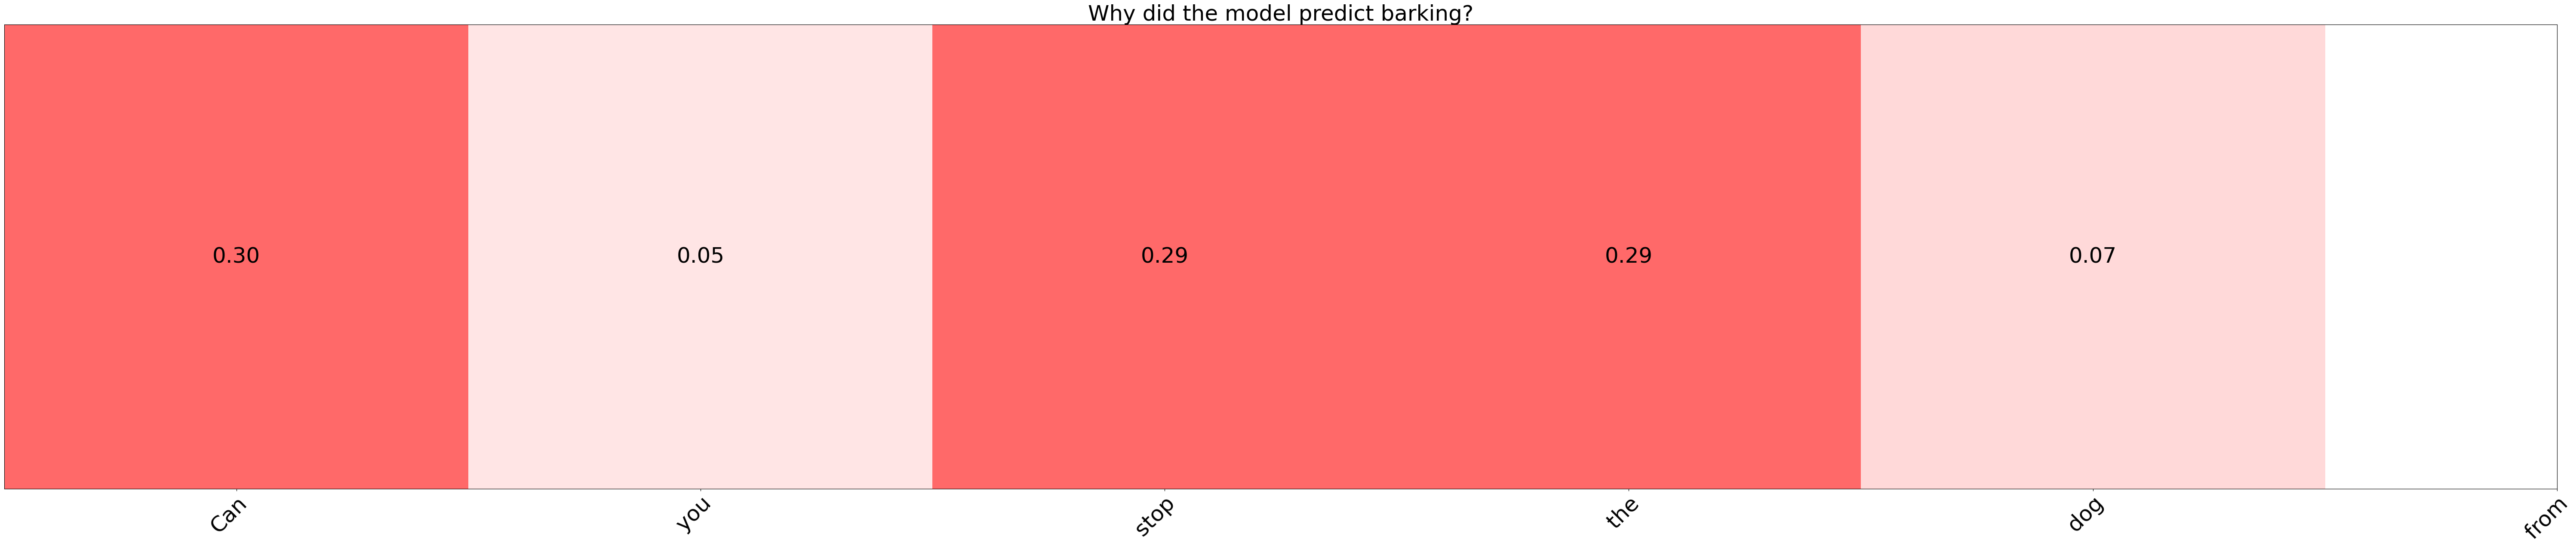

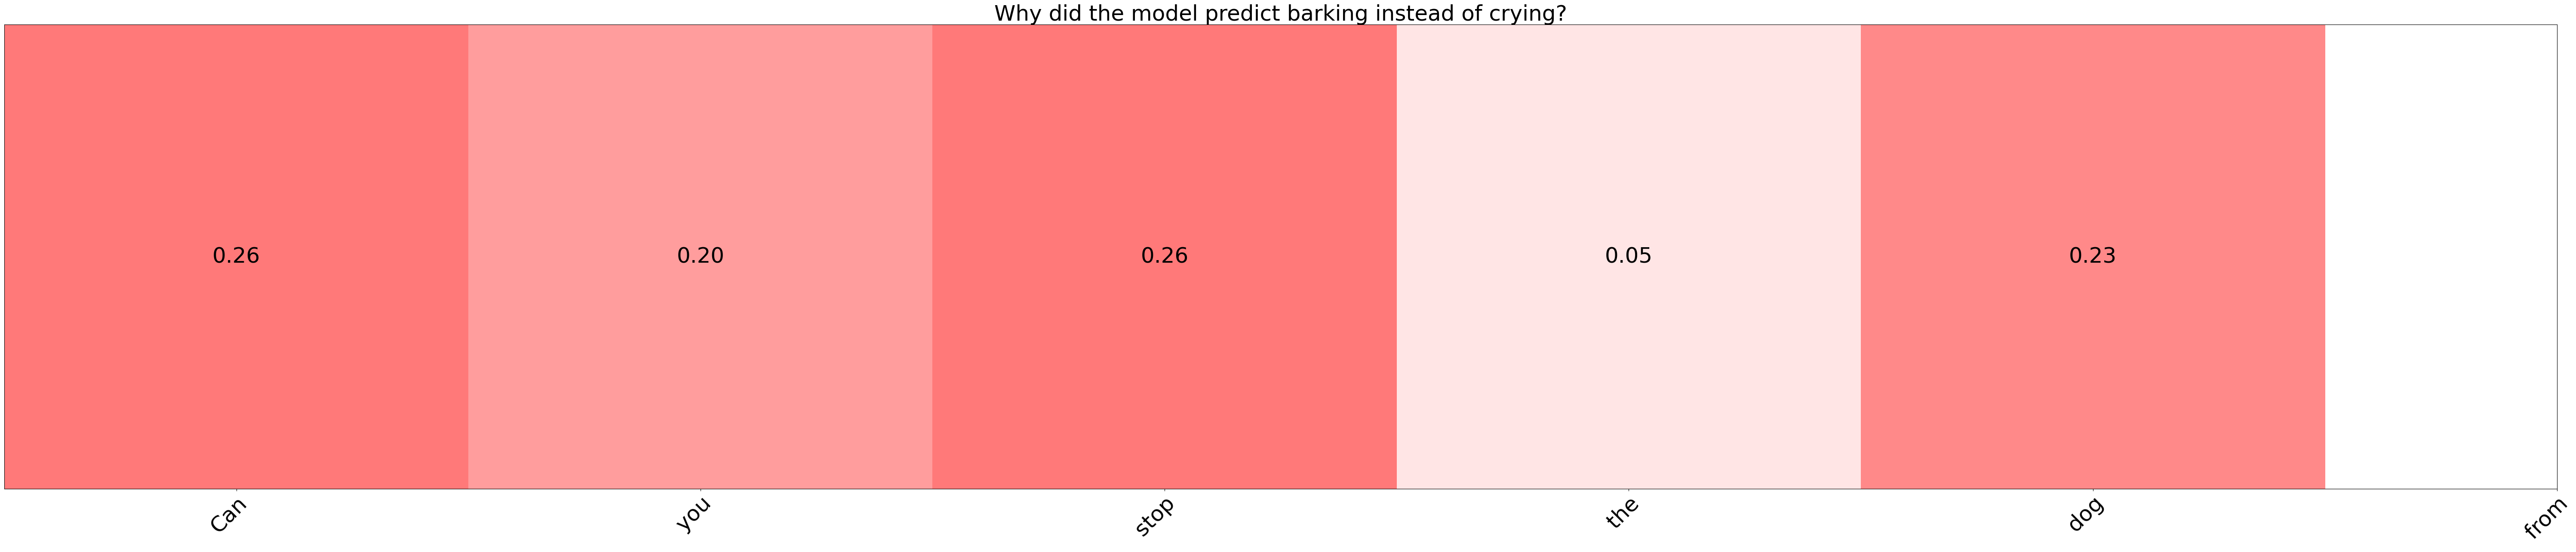

In [27]:
target = "barking" # target refers to the word we would like to generate explanation on
foil = "crying" # foil refers to any other possible word 
explanation = "erasure"
CORRECT_ID = gpt2_tokenizer(" " + target)["input_ids"][0]
FOIL_ID = gpt2_tokenizer(" " + foil)["input_ids"][0]

# Erasure
base_explanation = erasure_scores(gpt2_model, input_tokens, attention_ids, normalize=True)
contra_explanation = erasure_scores(gpt2_model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)

visualize(np.array(base_explanation), gpt2_tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target}?")
visualize(np.array(contra_explanation), gpt2_tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target} instead of {foil}?")

The score measures how much each token influences the model to attribute a higher probability to the target token. In this example above, `stop` makes the model more likely to predict `barking` whereas `the` doesn't influence whether the model predicts `barking` or `crying`.  

How we can use contrastive explanation to improve LLMs is still an ongoing research. 

It's not surprising that the research so far has shown that contrastive explanation can help us characterize how LLMs decide which output token to predict. It's an exciting space to watch for development.
